# Note 
All tests are already conducted with QuantReg. In most cases, we decided for the optimal variables based on the MSPE of the 50% quantile, thus the quantile Loss of this quantile. Hence, these tests should lead to the same results as the corresponding tests conduced with OLS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from energy_consumption.feature_selection.extract import extract_all_features

## Optimal Length of Observations
Comparison based on MSE

Extract energydata and features for Quantile Regression
Include relevant data (based on knowledge January 20, 2024)

In [ ]:
energydata = extract_all_features.get_energy_and_features(quantRegFinal1=True)

# ensure all test datasets have same length
energydata_test1 = energydata[0:-500]
energydata_test2 = energydata[100:-400]
energydata_test3 = energydata[200:-300]
energydata_test4 = energydata[300:-200]
energydata_test5 = energydata[400:-100]
energydata_test6 = energydata[500:]

# quick test
len(energydata_test1) == len(energydata_test6)

### QuantReg Model for Energy Data based on its Time Series

Adjust length of training data set for final model, 
* shrunkate data set on upper front for different predictions
* evaluate models based on r_squared
* solely train for 50% Quantile for simplicity --> Basically the same results as OLS
* Decide based on R_squared

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

data = [energydata_test1, energydata_test2, energydata_test3, energydata_test4, energydata_test5, energydata_test6]

length_adjuster = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7,
                   0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35,
                   0.3, 0.25, 0.2, 0.16, 0.1, 0.05]

max_length = len(energydata_test1)
r_squareds = {}
mspes = {}

for l in length_adjuster: 

    r_squared_l = []
    mspe_l = []
    
    for dataset in data: 

        # am oberen Ende kürzen --> unterschiedliche Forecasts
        energydata_temp = dataset[:int(l*max_length)]

        X = energydata_temp.drop(columns=['energy_consumption'])
        X.insert(loc=0, column='constant', value=1)
        y = energydata_temp['energy_consumption']

        X_train, X_test = X.iloc[:-100], X.iloc[-100:]
        y_train, y_test = y.iloc[:-100], y.iloc[-100:]

        # Initialize QuantReg model
        quantreg_model = sm.QuantReg(y_train, X_train)

        # Fit the initial model for 50% Quantile 
        quantreg_results = quantreg_model.fit(q=0.5)

        # Calculate R squared
        y_hat = quantreg_results.predict(X_train)
        y_mean = np.mean(y_train)
        r_squared = 1 - (np.sum((y_train - y_hat)**2) / np.sum((y_train - y_mean)**2))
        r_squared_l.append(r_squared)

        # Calculate MSPE
        y_pred = quantreg_results.predict(X_test)
        mspe = mean_squared_error(y_test, y_pred)
        mspe_l.append(mspe)

    print('----------l = ', l, '-----------')
    print("R_squared", r_squared_l)
    print("MSPE", mspe_l)

    r_squareds.update({l: r_squared_l})
    mspes.update({l: mspe_l})

In [ ]:
r_squared_summary = {}
mspe_summary = {}
for l in length_adjuster: 
    r_squared_summary[l] = np.mean(r_squareds[l])
    mspe_summary[l] = np.mean(mspes[l])

([<matplotlib.axis.XTick at 0x26b67920490>,
 [Text(0.1, 0, '6004'),
  Text(0.3, 0, '18012'),
  Text(0.5, 0, '30020'),
  Text(0.7, 0, '42029'),
  Text(0.9, 0, '54037')])

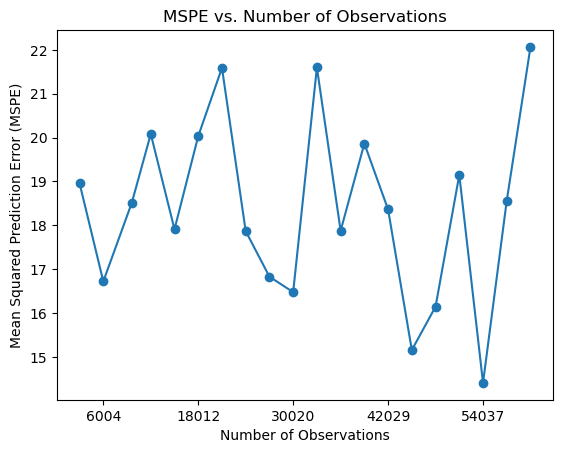

In [ ]:
# Extract keys and values from the dictionary
lengths = list(mspe_summary.keys())
mspe_values = list(mspe_summary.values())

# Plot the MSEs
plt.plot(lengths, mspe_values, marker='o')
plt.title('MSPE vs. Number of Observations')
plt.xlabel('Number of Observations')
plt.ylabel('Mean Squared Prediction Error (MSPE)')

xticks = [0.1 * 60041, 0.3 * 60041, 0.5 * 60041, 0.7 * 60041, 0.9 * 60041]
plt.xticks(ticks = [0.1, 0.3, 0.5, 0.7, 0.9], labels=[f'{val:.0f}' for val in xticks])

In [3]:
# R-Squared usually increases with number of observations, decide based on MSE, whereas no trend observable
opt_num_obs = 54027

### QuantReg Model for EnergyData based on Features
Focus on the subset of new features --> cluster dummies a little and include all new features to see how much they can explain

In [4]:
energydata = extract_all_features.get_energy_and_features(feature_selection=True)
energydata_fm = energydata[-opt_num_obs:]

X = energydata_fm.drop(columns=['energy_consumption'])
y = energydata_fm['energy_consumption']

2016-12-26 00:00:00
2023-11-23 12:00:00


We already know that seasonality plays a big role --> Dummies are probably highly significant 
Check last new features (sun hours, temperature, political instability, .. for significance and start with relatively high k due to computational time)

In [ ]:
# Perform time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=100)

# Dictionary to store MSPE for different feature selections
mspes_fe = {}

# Define a function to perform RFE using QuantReg (eliminate features based on their p values)
def recursive_feature_elimination(X, y, n_features_to_select):
    selected_features = list(X.columns)
    while len(selected_features) > n_features_to_select:
        X = X[selected_features]
        X.insert(loc=0, column='constant', value=1)
        model = sm.QuantReg(y,X)
        results = model.fit(q=0.5)
        p_values = results.pvalues[1:]
        worst_feature = p_values.idxmax()
        print(selected_features)
        print(worst_feature)
        selected_features.remove(worst_feature)
    return selected_features

# Set the number of features you want to select
n_features_to_select = [1,2,3,4,5,6,7,8,9,
                        10,11,12,13,14,15, 16, 17]

for n in n_features_to_select:

    # Lists to store results for each split
    mspe_splits = []

    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Perform RFE using QuantReg
        selected_features_rfe = recursive_feature_elimination(
            X_train, y_train, n)

        # Train the final model using the selected features
        X_final = X_train[selected_features_rfe]
        X_final.insert(loc=0, column='constant', value=1)
        final_quantreg_model = sm.QuantReg(
            y_train, X_final)
        final_quantreg_results = final_quantreg_model.fit(q=0.5)

        # predict 50% quantile (mean)
        X_test_final = X_test[selected_features_rfe]
        X_test_final.insert(loc=0, column='constant', value=1)
        y_pred = final_quantreg_results.predict(X_test_final)

        # Evaluate model
        mspe = mean_squared_error(y_test, y_pred)
        mspe_splits.append(mspe)

    # Average MSPE across splits
    mspe_avg = np.mean(mspe_splits)

    print('----------n = ', n, '-----------')
    print("Average Mean Squared Error", mspe_avg)
    print('Selected_features: ', selected_features_rfe)

    # Store the results in the dictionary
    mspes_fe.update({n: mspe_avg})

In [ ]:
X.columns

Index(['period1', 'period2', 'period3', 'period4', 'period5', 'period6',
       'saturday', 'working_day', 'winter', 'spring_autumn', 'holiday',
       'abs_log_ret_weekly', 'sun_hours', 'tavg', 'wspd', 'index',
       'population'],
      dtype='object')

([<matplotlib.axis.XTick at 0x2ae35edc890>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17')])

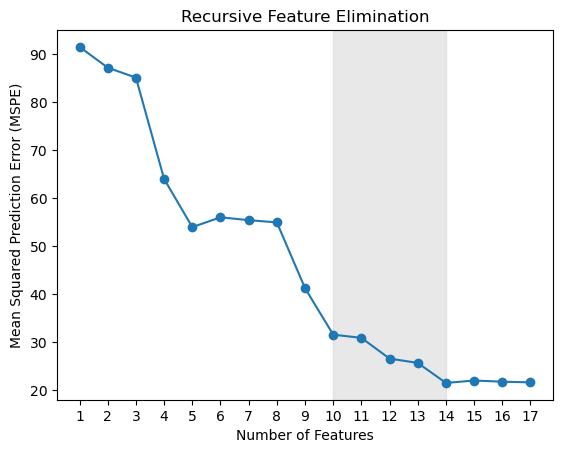

In [20]:
import matplotlib.pyplot as plt

# Extract keys and values from the dictionary
n_features = list(mspes_fe.keys())
mspe_values = list(mspes_fe.values())

# Plot the MSEs
plt.plot(n_features, mspe_values, marker='o')
plt.title('Recursive Feature Elimination')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Prediction Error (MSPE)')
plt.axvspan(10, 14, color='lightgrey', alpha=0.5)
plt.xticks(range(min(n_features), max(n_features) + 1))

RFE shows: 
* n = 14 performs the best
* variables to exclude: population, spring_autumn, abs_log_ret_weekly
* no month/season mapping --> weather data better proxy

Select the following variables for quantile regression: 
* periods/hours
* days/ working days
* holidays 
* sun_hours
* tavg
* wspd
* index
Considerable: tavg, wspd

Lastly, compare quantile regression with all days, seasons and hours as dummies with aggregated data and left out wspd and tavg (corr of 0.75 with sun_hours, sun_hours deterministic and both show same correlation with ec:)

In [24]:
energydata_fm.corr()

,energy_consumption,period1,period2,period3,period4,period5,period6,saturday,working_day,winter,spring_autumn,holiday,abs_log_ret_weekly,sun_hours,tavg,wspd,index,population
energy_consumption,1.000000,0.135978,-0.493718,0.308092,-0.070569,0.059154,0.289666,-0.222000,0.453516,0.237242,-0.027695,-0.172829,-0.033139,-0.295561,-0.300580,0.150936,0.195585,-0.174425
period1,0.135978,1.000000,-0.093245,-0.133792,-0.078806,-0.062866,-0.078826,0.000115,-0.000093,0.000007,-0.000011,0.000002,-0.000001,0.000061,0.000094,-0.000012,0.000134,-0.000129
period2,-0.493718,-0.093245,1.000000,-0.286951,-0.169020,-0.134831,-0.169063,-0.000321,0.000241,0.000014,-0.000024,0.000005,0.000058,-0.000109,-0.000190,0.000071,-0.000290,0.000288
period3,0.308092,-0.133792,-0.286951,1.000000,-0.242518,-0.193463,-0.242580,0.000238,-0.000195,0.000020,-0.000035,0.000007,0.000009,0.000137,0.000208,-0.000018,0.000293,-0.000281
period4,-0.070569,-0.078806,-0.169020,-0.242518,1.000000,-0.113954,-0.142884,0.000049,-0.000044,0.000012,-0.000020,0.000004,0.000015,0.000043,0.000060,0.000005,0.000080,-0.000075
period5,0.059154,-0.062866,-0.134831,-0.193463,-0.113954,1.000000,-0.113982,-0.000025,0.000014,0.000009,-0.000016,0.000003,0.000019,0.000007,0.000004,0.000015,-0.000001,0.000004
period6,0.289666,-0.078826,-0.169063,-0.242580,-0.142884,-0.113982,1.000000,0.000140,-0.000062,-0.000083,0.000143,-0.000027,-0.000156,-0.000096,-0.000087,-0.000119,-0.000072,0.000046
saturday,-0.222000,0.000115,-0.000321,0.000238,0.000049,-0.000025,0.000140,1.000000,-0.645206,0.002126,-0.002185,-0.034138,-0.000020,0.000140,-0.002716,0.004835,-0.007277,0.000382
working_day,0.453516,-0.000093,0.000241,-0.000195,-0.000044,0.000014,-0.000062,-0.645206,1.000000,-0.003063,0.001018,0.052953,0.000531,-0.000027,0.003734,0.005015,0.011248,-0.000455
winter,0.237242,0.000007,0.000014,0.000020,0.000012,0.000009,-0.000083,0.002126,-0.003063,1.000000,-0.578965,0.050283,-0.072718,-0.654430,-0.583305,0.280932,-0.233030,-0.045191


In [12]:
# this time: compare based on mean pinball loss --> important result

from sklearn.metrics import mean_pinball_loss

energydata_agg = energydata_fm.drop(
    columns=['population','spring_autumn', 'abs_log_ret_weekly'])

# Perform time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=100)

X = energydata_agg.drop(columns=['energy_consumption'])
y = energydata_agg[['energy_consumption']]
X.insert(loc=0, column='constant', value=1)

# Dictionary to store MSPE for different feature selections
scores_agg = {}
scores_spec = {}

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
overall_score_agg = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the final model using the selected features
    quantreg_model = sm.QuantReg(
            y_train, X_train)
    
    scores = []
    for q in quantiles: 

        # 50% quantile 
        model_results = quantreg_model.fit(q=q)
        y_pred = model_results.predict(X_test)
        score = mean_pinball_loss(y_test, y_pred, alpha=q)
        scores.append(score)
    
    overall_score_agg.append(np.mean(scores))

In [8]:
overall_score_agg

[0.9263126066692458,
 1.0421752293317912,
 0.9632849688061883,
 1.0178098228728187,
 0.9501135707558559]

In [10]:
energydata_spec = extract_all_features.get_energy_and_features(
    feature_selection_comp=True)[-opt_num_obs:]

# Perform same time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=100)

X = energydata_spec.drop(columns=['energy_consumption'])
y = energydata_agg[['energy_consumption']]
X.insert(loc=0, column='constant', value=1)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
overall_score_spec = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    quantreg_model = sm.QuantReg(
        y_train, X_train)

    scores = []
    for q in quantiles:
        model_results = quantreg_model.fit(q=q)
        y_pred_agg = model_results.predict(X_test)
        score = mean_pinball_loss(y_test, y_pred)
        scores.append(score)

    overall_score_spec.append(np.mean(scores))

2016-12-26 00:00:00
2023-11-23 12:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [11]:
overall_score_spec

[6.417965744431473,
 5.458116134369174,
 6.344934895122455,
 4.26275274903196,
 2.8771933194815147]

Significantly better performance of the aggregated model when it comes to quantile scores!!

In [4]:
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = impute_outliers(energydata)
energydata

,energy_consumption
date_time,
2016-12-26 00:00:00,41.81025
2016-12-26 01:00:00,39.73950
2016-12-26 02:00:00,38.78525
2016-12-26 03:00:00,38.96900
2016-12-26 04:00:00,39.18750
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


In [5]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame


def get_QuantReg_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], abs_eval = False):

    if type(energydata) == float:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data(num_years=6.17)  

    # get features
    if len(energydata) > 54027:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)[-54027:]
    else:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)

    X = energydata.drop(columns=[
                        'energy_consumption', 'population', 'spring_autumn', 'abs_log_ret_weekly'])
    X.insert(loc=0, column='constant', value=1)
    y = energydata['energy_consumption']

    # create dataframe to store forecast quantiles
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])
    
    X_pred = extract_all_features.get_energy_and_features(energyforecast,
                                                                  feature_selection=True)
    X_pred = X_pred.drop(columns=['population', 'spring_autumn', 'abs_log_ret_weekly'])
    X_pred.insert(loc=0, column='constant', value=1)
    
    # model
    model_qr = sm.QuantReg(y, X)

    for q in quantiles:
        model_temp = model_qr.fit(q=q)
        forecast_temp = model_temp.predict(X_pred)
        energyforecast[f'q{q}'] = forecast_temp
    
    first_name = f'q{quantiles[0]}'
    max_index = len(quantiles) - 1
    last_name = f'q{quantiles[max_index]}'

    selected_forecasts = energyforecast.loc[energyforecast.index[indexes],
                                            first_name:last_name]
    
    if abs_eval == False: 
        selected_forecasts = create_submission_frame.get_frame(
            selected_forecasts)

    return selected_forecasts

In [ ]:
forecasts = get_QuantReg_forecasts(energydata[:-168], indexes = list(range(100)), quantiles = [0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975], abs_eval = True)
forecasts


In [ ]:
energydata[-168:-100]

Absolute Model Evaluation 

In [15]:
import matplotlib.pyplot as plt

In [ ]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(1, 5):
    print(f'start of round {i}')
    forecasts = get_QuantReg_forecasts(energydata[:i*(-168)],
                                      indexes=list(range(80)),
                                      quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns: 
    pit_merged.insert(column_index, 'q1', float('inf'))

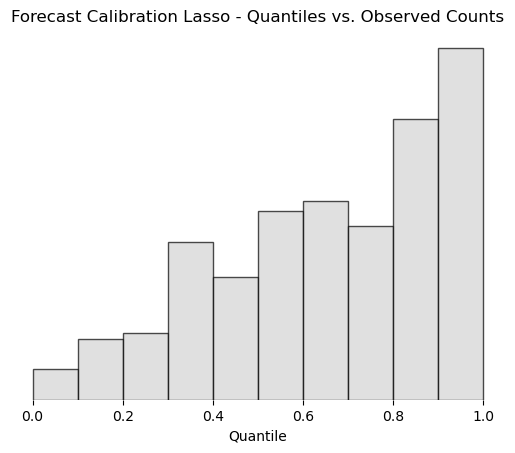

In [19]:
def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])
# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration QuantReg - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

# try out model with hour mappings
(maybe more accurate in higher day times)

In [22]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame


def get_QuantReg_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], abs_eval=False):

    if type(energydata) == float:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data(num_years=6.17)

    # get features
    if len(energydata) > 54027:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  lasso=True)[-54027:]
    else:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  lasso=True)

    X = energydata.drop(columns=[
                        'energy_consumption', 'population', 'spring_autumn', 'abs_log_ret_weekly'])
    X.insert(loc=0, column='constant', value=1)
    y = energydata['energy_consumption']

    # create dataframe to store forecast quantiles
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])

    X_pred = extract_all_features.get_energy_and_features(energyforecast,
                                                          lasso=True)
    X_pred = X_pred.drop(
        columns=['population', 'spring_autumn', 'abs_log_ret_weekly'])
    X_pred.insert(loc=0, column='constant', value=1)

    # model
    model_qr = sm.QuantReg(y, X)

    for q in quantiles:
        model_temp = model_qr.fit(q=q)
        forecast_temp = model_temp.predict(X_pred)
        energyforecast[f'q{q}'] = forecast_temp

    first_name = f'q{quantiles[0]}'
    max_index = len(quantiles) - 1
    last_name = f'q{quantiles[max_index]}'

    selected_forecasts = energyforecast.loc[energyforecast.index[indexes],
                                            first_name:last_name]

    if abs_eval == False:
        selected_forecasts = create_submission_frame.get_frame(
            selected_forecasts)

    return selected_forecasts

In [ ]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(1, 3):
    print(f'start of round {i}')
    forecasts = get_QuantReg_forecasts(energydata[:i*(-168)],
                                       indexes=list(range(80)),
                                       quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

In [30]:
def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else: 
        ordered_quantile_counts[q] = 0  

ordered_quantile_counts

{0.1: 0,
 0.2: 3,
 0.3: 9,
 0.4: 9,
 0.5: 12,
 0.6: 10,
 0.7: 30,
 0.8: 17,
 0.9: 45,
 1: 25}

result: not better
Ideas: 
- range(1,5) erhöhen --> Somme dafür andersrum 
- trainingsdatensatz verkleinern (nur winter)


## New solution: Post processing 
Korrigieren der Vorhersagen um mean 

In [38]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#extend range to get more accurate results
for i in range(1, 4):
    print(f'start of round {i}')
    forecasts = get_QuantReg_forecasts(energydata[:i*-168],
                                       indexes=list(range(80)),
                                       quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))

start of round 1
2016-12-26 00:00:00
2023-11-02 12:00:00
2023-11-01 13:00:00
2023-11-06 16:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


start of round 2
2016-12-26 00:00:00
2023-10-12 12:00:00
2023-10-11 13:00:00
2023-10-16 16:00:00
start of round 3
2016-12-26 00:00:00
2023-09-21 12:00:00
2023-09-20 13:00:00
2023-09-25 16:00:00


In [39]:
def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

ordered_quantile_counts

{0.1: 11,
 0.2: 20,
 0.3: 23,
 0.4: 25,
 0.5: 24,
 0.6: 25,
 0.7: 20,
 0.8: 29,
 0.9: 29}

Ergebnisse: 
- range(1,10): {0.1: 12,
 0.2: 32,
 0.3: 52,
 0.4: 73,
 0.5: 67,
 0.6: 82,
 0.7: 76,
 0.8: 90,
 0.9: 115} --> Keine Verbesserung 

- Zeitpunkte Vorhersage ändern: {0.1: 11,
 0.2: 20,
 0.3: 23,
 0.4: 25,
 0.5: 24,
 0.6: 25,
 0.7: 20,
 0.8: 29,
 0.9: 29} --> Schon besser, vmtl Grund. Allerdings: Für scores am Ende nicht gut 

 - Lösungsansätze: 
 - Trainingsdatensatz massiv verkleinern 
 - residuen im nachgang anpassen 
 

In [44]:
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = impute_outliers(energydata)
energydata

,energy_consumption
date_time,
2016-12-26 00:00:00,41.81025
2016-12-26 01:00:00,39.73950
2016-12-26 02:00:00,38.78525
2016-12-26 03:00:00,38.96900
2016-12-26 04:00:00,39.18750
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


In [103]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame


def get_QuantReg_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], abs_eval=False):

    if type(energydata) == float:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data(num_years=0.25)

    # get features
    if len(energydata) > 720:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)[-720:]
    else:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)

    # new: drop index und winter, since they are not important for monthly forecasts
    X = energydata.drop(columns=[
                        'energy_consumption', 'population', 'spring_autumn', 'abs_log_ret_weekly', 'index', 'winter'])
    X.insert(loc=0, column='constant', value=1)
    y = energydata['energy_consumption']

    # create dataframe to store forecast quantiles
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])

    X_pred = extract_all_features.get_energy_and_features(energyforecast,
                                                          feature_selection=True)

    for col in ['population', 'spring_autumn', 'abs_log_ret_weekly', 'index', 'winter']:
        if col in X_pred.columns:
            X_pred = X_pred.drop(columns=[col])
    X_pred.insert(loc=0, column='constant', value=1)

    # model
    model_qr = sm.QuantReg(y, X)

    for q in quantiles:
        model_temp = model_qr.fit(q=q)
        forecast_temp = model_temp.predict(X_pred)
        energyforecast[f'q{q}'] = forecast_temp

    first_name = f'q{quantiles[0]}'
    max_index = len(quantiles) - 1
    last_name = f'q{quantiles[max_index]}'

    selected_forecasts = energyforecast.loc[energyforecast.index[indexes],
                                            first_name:last_name]

    if abs_eval == False:
        selected_forecasts = create_submission_frame.get_frame(
            selected_forecasts)

    return selected_forecasts

In [104]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# extend range to get more accurate results
for i in range(1,20):
    print(f'start of round {i}')
    forecasts = get_QuantReg_forecasts(energydata[:i*-168],
                                       indexes=list(range(80)),
                                       quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))

start of round 1
2022-01-31 00:00:00
2024-01-11 12:00:00
2024-01-10 13:00:00
2024-01-15 16:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


start of round 2
2022-01-31 00:00:00
2024-01-04 12:00:00
2024-01-03 13:00:00
2024-01-08 16:00:00
start of round 3
2022-01-31 00:00:00
2023-12-28 12:00:00
2023-12-27 13:00:00
2024-01-01 16:00:00
start of round 4
2022-01-31 00:00:00
2023-12-21 12:00:00
2023-12-20 13:00:00
2023-12-25 16:00:00
start of round 5
2022-01-31 00:00:00
2023-12-14 12:00:00
2023-12-13 13:00:00
2023-12-18 16:00:00
start of round 6
2022-01-31 00:00:00
2023-12-07 12:00:00
2023-12-06 13:00:00
2023-12-11 16:00:00
start of round 7
2022-01-31 00:00:00
2023-11-30 12:00:00
2023-11-29 13:00:00
2023-12-04 16:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


start of round 8
2022-01-31 00:00:00
2023-11-23 12:00:00
2023-11-22 13:00:00
2023-11-27 16:00:00
start of round 9
2022-01-31 00:00:00
2023-11-16 12:00:00
2023-11-15 13:00:00
2023-11-20 16:00:00
start of round 10
2022-01-31 00:00:00
2023-11-09 12:00:00
2023-11-08 13:00:00
2023-11-13 16:00:00
start of round 11
2022-01-31 00:00:00
2023-11-02 12:00:00
2023-11-01 13:00:00
2023-11-06 16:00:00
start of round 12
2022-01-31 00:00:00
2023-10-26 12:00:00
2023-10-25 13:00:00
2023-10-30 16:00:00
start of round 13
2022-01-31 00:00:00
2023-10-19 12:00:00
2023-10-18 13:00:00
2023-10-23 16:00:00
start of round 14
2022-01-31 00:00:00
2023-10-12 12:00:00
2023-10-11 13:00:00
2023-10-16 16:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


start of round 15
2022-01-31 00:00:00
2023-10-05 12:00:00
2023-10-04 13:00:00
2023-10-09 16:00:00
start of round 16
2022-01-31 00:00:00
2023-09-28 12:00:00
2023-09-27 13:00:00
2023-10-02 16:00:00
start of round 17
2022-01-31 00:00:00
2023-09-21 12:00:00
2023-09-20 13:00:00
2023-09-25 16:00:00
start of round 18
2022-01-31 00:00:00
2023-09-14 12:00:00
2023-09-13 13:00:00
2023-09-18 16:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


start of round 19
2022-01-31 00:00:00
2023-09-07 12:00:00
2023-09-06 13:00:00
2023-09-11 16:00:00


In [75]:
pit_merged

,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,energy_consumption,first_quantile
0,2023-11-15 13:00:00,62.020657,64.088780,64.562356,64.860089,65.645578,66.724557,66.933314,68.365165,69.300532,inf,65.83350,q0.6
1,2023-11-15 14:00:00,59.461924,62.212378,63.098646,64.010973,64.512505,65.190044,65.716605,66.850738,67.603614,inf,63.93950,q0.4
2,2023-11-15 15:00:00,59.461924,62.212378,63.098646,64.010973,64.512505,65.190044,65.716605,66.850738,67.603614,inf,63.17325,q0.4
3,2023-11-15 16:00:00,59.461924,62.212378,63.098646,64.010973,64.512505,65.190044,65.716605,66.850738,67.603614,inf,64.27325,q0.5
4,2023-11-15 17:00:00,59.461924,62.212378,63.098646,64.010973,64.512505,65.190044,65.716605,66.850738,67.603614,inf,66.69150,q0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-07-15 16:00:00,45.939296,46.303129,46.723075,47.039020,47.556297,47.986890,48.427416,50.016019,51.530633,inf,47.06350,q0.5
76,2023-07-15 17:00:00,45.939296,46.303129,46.723075,47.039020,47.556297,47.986890,48.427416,50.016019,51.530633,inf,46.77025,q0.4
77,2023-07-15 18:00:00,45.939296,46.303129,46.723075,47.039020,47.556297,47.986890,48.427416,50.016019,51.530633,inf,47.65075,q0.6
78,2023-07-15 19:00:00,45.939296,46.303129,46.723075,47.039020,47.556297,47.986890,48.427416,50.016019,51.530633,inf,47.43225,q0.5


In [76]:
def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

# order quantiles for final plot
ordered_quantile_counts = {}
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

ordered_quantile_counts

{0.1: 124,
 0.2: 123,
 0.3: 127,
 0.4: 135,
 0.5: 142,
 0.6: 150,
 0.7: 153,
 0.8: 196,
 0.9: 130,
 1: 240}

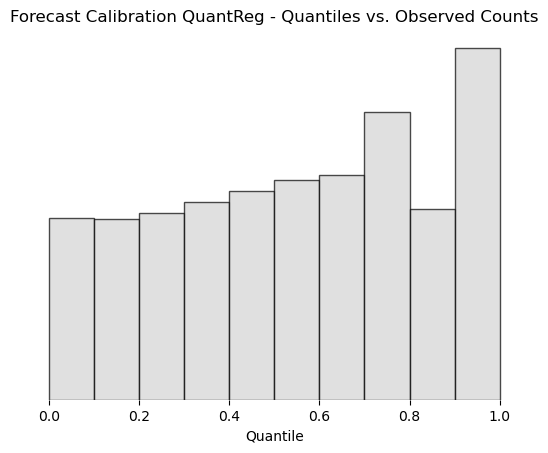

In [77]:
def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']

counts = list(ordered_quantile_counts.values())
bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])
# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration QuantReg - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

Annahme: Plot ok --> November steigt stark an, daher EC höher mit Zeit, Januar aber relativ konstant --> ok für score, stunden und wochentage dafür in Lasso integrieren!

wird besser! 
2 monate: 
{0.1: 6,
 0.2: 12,
 0.3: 11,
 0.4: 31,
 0.5: 29,
 0.6: 15,
 0.7: 28,
 0.8: 31,
 0.9: 17}
 1 monat: 
{0.1: 14, 0.2: 20, 0.3: 9, 0.4: 16, 0.5: 18, 0.6: 9, 0.7: 14, 0.8: 39, 0.9: 11} 
 

# Calibrate using new data

In [2]:
from energy_consumption.feature_selection.extract import extract_energy_data
energydata = extract_energy_data.get_data(num_years=0.7)

100%|██████████| 36/36 [00:26<00:00,  1.38it/s]


In [29]:
def get_value_to_add(i, col_name):
    # Extract the numerical part from the column name
    q_value = float(col_name[1:])
    if i < 24:
        return 1 if q_value < 0.5 else -1
    elif i <= 48:
        return np.sqrt(2) if q_value < 0.5 else -np.sqrt(2)
    elif i <= 72:
        return np.sqrt(3) if q_value < 0.5 else -np.sqrt(3)
    elif i < 86:
        return np.sqrt(4) if q_value < 0.5 else -np.sqrt(4)
    else:
        return np.sqrt(5) if q_value < 0.5 else -np.sqrt(5)


In [8]:
def get_value_to_add2(i, col_name):
    q_value = float(col_name[1:])
    if q_value < 0.5:
        return np.sqrt(i/24)
    else:
        return (-np.sqrt(i/24))

# Am Ende:
    # for col in selected_forecasts.columns:
    # selected_forecasts[col] = selected_forecasts.apply(lambda row: get_value_to_add(row.name, col), axis=1) + selected_forecasts[col]

In [3]:
import pandas as pd
import numpy as np

from scipy.stats import norm

import statsmodels.api as sm

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame


def get_QuantReg_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], abs_eval=False):

    if type(energydata) == float:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data(num_years=0.25)

    # get features
    if len(energydata) > 1000:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection_comp=True)[-1000:]     #1440
    else:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection_comp=True)

    # new: drop index und winter, since they are not important for monthly forecasts
    X = energydata.drop(columns=['energy_consumption'])
    X.insert(loc=0, column='constant', value=1)
    y = energydata['energy_consumption']

    # create dataframe to store forecast quantiles
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])

    X_pred = extract_all_features.get_energy_and_features(energyforecast,
                                                          feature_selection_comp=True)
    X_pred.insert(loc=0, column='constant', value=1)

    # model
    model_qr = sm.QuantReg(y, X)

    for q in quantiles:
        model_temp = model_qr.fit(q=q)
        
        forecast_temp = model_temp.predict(X_pred) 
        energyforecast[f'q{q}'] = forecast_temp + norm.ppf(q, loc=0)*2.5
        

    first_name = f'q{quantiles[0]}'
    max_index = len(quantiles) - 1
    last_name = f'q{quantiles[max_index]}'

    selected_forecasts = energyforecast.loc[energyforecast.index[indexes],
                                            first_name:last_name]
    
    #for col in selected_forecasts.columns:
    #    selected_forecasts[col] = selected_forecasts.apply(lambda row: get_value_to_add(
    #        selected_forecasts.index.get_loc(row.name), col), axis=1) + selected_forecasts[col]

    if abs_eval == False:
        selected_forecasts = create_submission_frame.get_frame(
            selected_forecasts)

    return selected_forecasts

In [ ]:
pit_merged2 = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# extend range to get more accurate results
for i in range(1, 8):
    print(f'start of round {i}')
    forecasts = get_QuantReg_forecasts(energydata[:i*-168],
                                       indexes=list(range(80)),
                                       quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged2 = pd.concat([pit_merged2, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged2.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged2.columns:
    pit_merged2.insert(column_index, 'q1', float('inf'))

In [7]:
column_index = pit_merged2.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged2.columns:
    pit_merged2.insert(column_index, 'q1', float('inf'))
pit_merged2

,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,energy_consumption
0,2024-01-17 13:00:00,62.974596,67.159909,69.439110,70.666632,72.754466,74.321277,75.887329,77.088417,78.567800,inf,71.60325
1,2024-01-17 14:00:00,62.021097,66.050763,67.750970,69.434856,71.215585,73.103277,74.588441,75.780543,77.481983,inf,70.62675
2,2024-01-17 15:00:00,61.679598,65.955763,67.752457,69.047626,70.782981,72.609661,74.032075,75.238667,77.251483,inf,69.26850
3,2024-01-17 16:00:00,63.054097,67.151763,68.818721,70.295626,71.617981,73.127037,74.559079,75.760803,77.519734,inf,69.43150
4,2024-01-17 17:00:00,65.420848,69.995447,71.074068,72.275132,73.245144,74.854288,76.077826,77.087874,78.844191,inf,71.15625
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-12-09 16:00:00,52.794265,54.332260,55.298152,55.430626,55.839654,58.192472,59.704776,63.059691,65.194158,inf,56.23250
76,2023-12-09 17:00:00,54.873265,56.009386,57.160131,57.447370,58.112570,60.139623,61.710020,64.402762,66.493408,inf,58.59900
77,2023-12-09 18:00:00,54.060927,55.474961,56.756568,57.131370,57.640612,59.739155,61.065255,63.694817,65.682406,inf,58.75275
78,2023-12-09 19:00:00,52.373428,53.705545,55.080605,55.269119,55.920340,58.018525,59.314474,62.091568,64.067401,inf,57.35425


In [8]:
import matplotlib.pyplot as plt


def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged2['first_quantile'] = pit_merged2.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged2['first_quantile'].value_counts()


quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 94,
 0.2: 78,
 0.3: 75,
 0.4: 51,
 0.5: 50,
 0.6: 55,
 0.7: 45,
 0.8: 67,
 0.9: 36,
 1: 9}

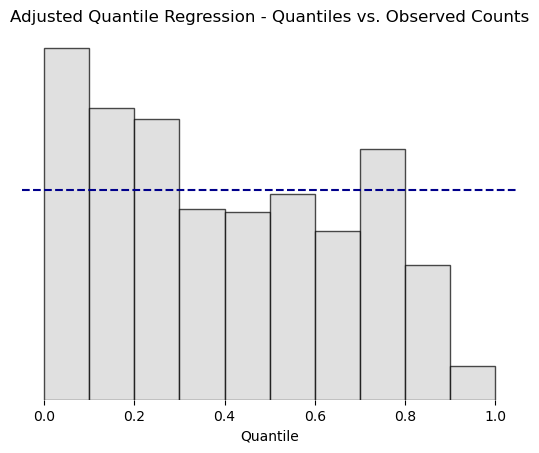

In [9]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

# Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Adjusted Quantile Regression - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

In [80]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame


def get_QuantRegShort_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], abs_eval=False):

    if type(energydata) == float:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data(num_years=0.25)

    # get features
    if len(energydata) > 1440:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)[-1440:]
    else:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)

    # new: drop index und winter, since they are not important for monthly forecasts
    X = energydata.drop(columns=[
                        'energy_consumption', 'population', 'spring_autumn', 'abs_log_ret_weekly', 'index', 'winter'])
    X.insert(loc=0, column='constant', value=1)
    y = energydata['energy_consumption']

    # create dataframe to store forecast quantiles
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])

    X_pred = extract_all_features.get_energy_and_features(energyforecast,
                                                          feature_selection=True)

    for col in ['population', 'spring_autumn', 'abs_log_ret_weekly', 'index', 'winter']:
        if col in X_pred.columns:
            X_pred = X_pred.drop(columns=[col])
    X_pred.insert(loc=0, column='constant', value=1)

    # model
    model_qr = sm.QuantReg(y, X)

    for q in quantiles:
        model_temp = model_qr.fit(q=q)
        forecast_temp = model_temp.predict(X_pred)
        energyforecast[f'q{q}'] = forecast_temp

    first_name = f'q{quantiles[0]}'
    max_index = len(quantiles) - 1
    last_name = f'q{quantiles[max_index]}'

    selected_forecasts = energyforecast.loc[energyforecast.index[indexes],
                                            first_name:last_name]

    if abs_eval == False:
        selected_forecasts = create_submission_frame.get_frame(
            selected_forecasts)

    return selected_forecasts

In [81]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# extend range to get more accurate results
for i in range(1, 8):
    print(f'start of round {i}')
    forecasts = get_QuantRegShort_forecasts(energydata[:i*-168],
                                       indexes=list(range(80)),
                                       quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))

start of round 1
2023-05-22 00:00:00
2024-01-18 12:00:00
2024-01-17 13:00:00
2024-01-22 16:00:00
start of round 2
2023-05-22 00:00:00
2024-01-11 12:00:00
2024-01-10 13:00:00
2024-01-15 16:00:00


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


start of round 3
2023-05-22 00:00:00
2024-01-04 12:00:00
2024-01-03 13:00:00
2024-01-08 16:00:00
start of round 4
2023-05-22 00:00:00
2023-12-28 12:00:00
2023-12-27 13:00:00
2024-01-01 16:00:00
start of round 5
2023-05-22 00:00:00
2023-12-21 12:00:00
2023-12-20 13:00:00
2023-12-25 16:00:00
start of round 6
2023-05-22 00:00:00
2023-12-14 12:00:00
2023-12-13 13:00:00
2023-12-18 16:00:00
start of round 7
2023-05-22 00:00:00
2023-12-07 12:00:00
2023-12-06 13:00:00
2023-12-11 16:00:00


In [82]:
import matplotlib.pyplot as plt


def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()


quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 168,
 0.2: 65,
 0.3: 37,
 0.4: 37,
 0.5: 26,
 0.6: 23,
 0.7: 27,
 0.8: 27,
 0.9: 27,
 1: 123}

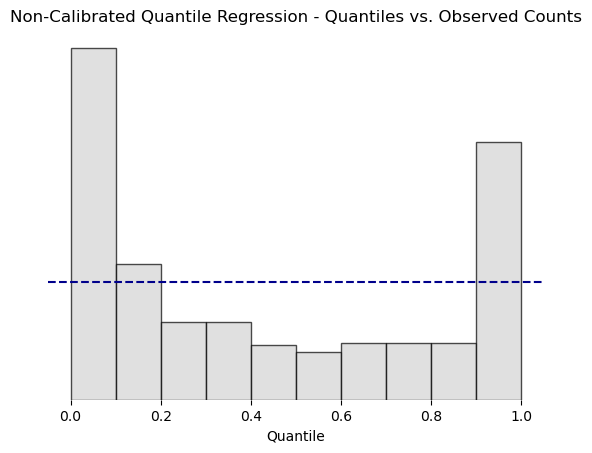

In [83]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

# Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Non-Calibrated Quantile Regression - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

In [14]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame


def get_QuantRegExShort_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], abs_eval=False):

    if type(energydata) == float:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data(num_years=0.25)

    # get features
    if len(energydata) > 1440:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)[-1440:]
    else:
        energydata = extract_all_features.get_energy_and_features(energydata,
                                                                  feature_selection=True)

    # new: drop index und winter, since they are not important for monthly forecasts
    X = energydata.drop(columns=[
                        'energy_consumption', 'population', 'spring_autumn', 'abs_log_ret_weekly', 'index', 'winter', 'tavg', 'wspd'])
    X.insert(loc=0, column='constant', value=1)
    y = energydata['energy_consumption']

    # create dataframe to store forecast quantiles
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])

    X_pred = extract_all_features.get_energy_and_features(energyforecast,
                                                          feature_selection=True)

    for col in ['population', 'spring_autumn', 'abs_log_ret_weekly', 'index', 'winter', 'tavg', 'wspd']:
        if col in X_pred.columns:
            X_pred = X_pred.drop(columns=[col])
    X_pred.insert(loc=0, column='constant', value=1)

    # model
    model_qr = sm.QuantReg(y, X)

    for q in quantiles:
        model_temp = model_qr.fit(q=q)
        forecast_temp = model_temp.predict(X_pred)
        energyforecast[f'q{q}'] = forecast_temp

    first_name = f'q{quantiles[0]}'
    max_index = len(quantiles) - 1
    last_name = f'q{quantiles[max_index]}'

    selected_forecasts = energyforecast.loc[energyforecast.index[indexes],
                                            first_name:last_name]

    if abs_eval == False:
        selected_forecasts = create_submission_frame.get_frame(
            selected_forecasts)

    return selected_forecasts

In [15]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# extend range to get more accurate results
for i in range(1, 8):
    print(f'start of round {i}')
    forecasts = get_QuantRegShort_forecasts(energydata[:i*-168],
                                            indexes=list(range(80)),
                                            quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))

start of round 1


NameError: name 'get_QuantRegShort_forecasts' is not defined

In [86]:
import matplotlib.pyplot as plt


def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()


quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 168,
 0.2: 65,
 0.3: 37,
 0.4: 37,
 0.5: 26,
 0.6: 23,
 0.7: 27,
 0.8: 27,
 0.9: 27,
 1: 123}

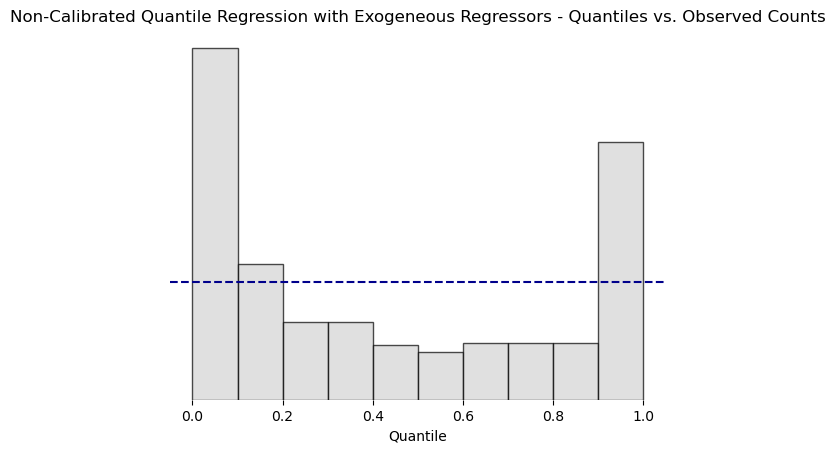

In [88]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

# Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Non-Calibrated Quantile Regression with Exogeneous Regressors - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()